# High-performance Evolutionary Algorithms for Online Neuron Control (GECCO 2022)

Binxu Wang, Carlos R. Ponce

**Author of notebook**: Binxu Wang (binxu_wang@hms.harvard.edu)

**Github Repo**: https://github.com/Animadversio/ActMax-Optimizer-Dev

## Set up 

Set up dependency and import basics

In [1]:
!git clone https://github.com/maochengxu/ActMax-Optimizer-Dev.git
!pip install cma==3.0.3
!pip install nevergrad==0.4.2.post5
# !pip install pytorch_pretrained_biggan
%cd ActMax-Optimizer-Dev
%mkdir tmp

Cloning into 'ActMax-Optimizer-Dev'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 375 (delta 4), reused 5 (delta 2), pack-reused 300
Receiving objects: 100% (375/375), 998.41 KiB | 20.80 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
/home/paperspace/mlproj2/ActMax-Optimizer-Dev


In [2]:
!git pull

Already up to date.


In [1]:
import torch
import numpy as np
from matplotlib import animation
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [2]:
assert torch.cuda.is_available(), "Need a GPU runtime to run evolutions efficiently."

## Simple Evolution Experiment

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 2.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050


/home/paperspace/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


synth img scores: mean 1.161 +- std 0.000
step 0  time: total 0.09s | GAN visualize 0.00s   CNN score 0.02s   optimizer step 0.06s
sigma: 1.94
synth img scores: mean -0.371 +- std 0.793
step 1  time: total 0.67s | GAN visualize 0.08s   CNN score 0.54s   optimizer step 0.04s
sigma: 1.88
synth img scores: mean -0.057 +- std 0.737
step 2  time: total 0.63s | GAN visualize 0.06s   CNN score 0.53s   optimizer step 0.04s
sigma: 1.84
synth img scores: mean 0.102 +- std 0.785
step 3  time: total 0.77s | GAN visualize 0.05s   CNN score 0.52s   optimizer step 0.20s
sigma: 1.80
synth img scores: mean 0.023 +- std 1.015
step 4  time: total 0.72s | GAN visualize 0.06s   CNN score 0.53s   optimizer step 0.13s
sigma: 1.77
synth img scores: mean 0.576 +- std 0.962
step 5  time: total 0.64s | GAN visualize 0.06s   CNN score 0.54s   optimizer step 0.05s
sigma: 1.74
synth img scores: mean 1.110 +- std 1.366
step 6  time: total 0.63s | GAN visualize 0.06s   CNN score 0.53s   optimizer step 0.04s
sigma: 1.

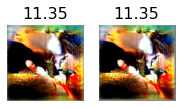

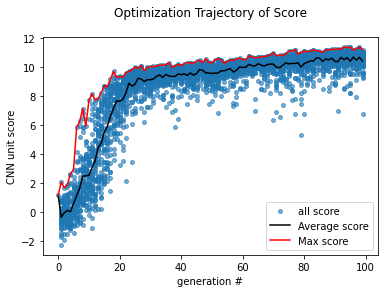

Last generation and Best code saved.


In [3]:
from core.insilico_exps import ExperimentEvolution
from core.Optimizers import CholeskyCMAES, ZOHA_Sphere_lr_euclid, Genetic, pycma_optimizer

tmpsavedir = "tmp" # Temporary save directory

# load optimizer
optim = CholeskyCMAES(4096, population_size=40, init_sigma=2.0, Aupdate_freq=10, init_code=np.zeros([1, 4096]))
# un-comment to use our new one! 
# optim = ZOHA_Sphere_lr_euclid(4096, population_size=40, select_size=20, lr=1.5, sphere_norm=300)
# optim.lr_schedule(n_gen=75, mode="exp", lim=(50, 7.33) ,)
explabel, model_unit = "vit_b_16_exp", ("vit_b_16", ".heads.Linearhead", 1)
Exp = ExperimentEvolution(model_unit, savedir=tmpsavedir, explabel=explabel, optimizer=optim)
# run evolutions
Exp.run()
Exp.visualize_best()
Exp.visualize_trajectory()
Exp.save_last_gen()

## Animate the course of evolution

In [4]:
from core.GAN_utils import upconvGAN
G = upconvGAN("fc6")
G.cuda().eval();

In [5]:
avg_codes = [Exp.codes_all[Exp.generations == geni, :].mean(axis=0) for geni in range(100)]
avg_codes = np.stack(avg_codes)
avg_activ = np.array([Exp.scores_all[Exp.generations == geni].mean(axis=0) for geni in range(100)])
print(avg_codes.shape)
print(avg_activ.shape)

(100, 4096)
(100,)


In [6]:
imgs_per_gen = G.visualize_batch_np(avg_codes)
imgs_per_gen_np = imgs_per_gen.permute([0,2,3,1]).numpy()
print(imgs_per_gen.shape)

torch.Size([100, 3, 256, 256])


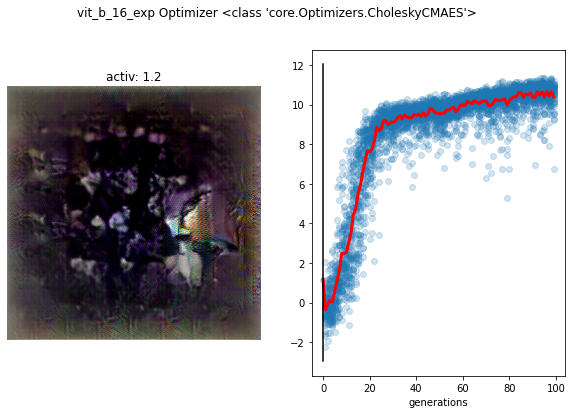

In [7]:
fig, axs = plt.subplots(1, 2, figsize=[10,6])
tit = axs[0].set_title(f"activ: {avg_activ[0]:.1f}")
ims = axs[0].imshow(imgs_per_gen_np[0])
axs[0].axis("Off")
axs[1].scatter(Exp.generations, Exp.scores_all, alpha=0.2)
axs[1].plot(range(100), avg_activ, c="red", lw=3)
axs[1].set_xlabel("generations")
fig.suptitle(f"{explabel} Optimizer {str(type(optim))}")
YLIM = axs[1].get_ylim()
lin1, = axs[1].plot([0,0], YLIM, color="k")
def drawframe_score(n):
    ims.set_data(imgs_per_gen_np[n])
    tit.set_text(f"activ: {avg_activ[n]:.1f}")
    lin1.set_data([n, n], YLIM)
    return (ims, tit, lin1) 

In [8]:
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe_score, frames=100, interval=100, blit=False, repeat=True)
anim

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 720x432 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp8hg5879c/temp.m4v
Error: unable to open display 
/tmp/tmp8hg5879c/temp.m4v: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '720x432', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp8hg5879c/temp.m4v']' returned non-zero exit status 1.

In [ ]:
#@title Make the Animation function `animate_evol_exp`, `animate_evol_images`
def animate_evol_exp(Exp: ExperimentEvolution):
    avg_codes = [Exp.codes_all[Exp.generations == geni, :].mean(axis=0) for geni in range(100)]
    avg_codes = np.stack(avg_codes)
    avg_activ = np.array([Exp.scores_all[Exp.generations == geni].mean(axis=0) for geni in range(100)])
    
    imgs_per_gen = G.visualize_batch_np(avg_codes)
    imgs_per_gen_np = imgs_per_gen.permute([0,2,3,1]).numpy()

    fig, axs = plt.subplots(1, 2, figsize=[10,6])
    tit = axs[0].set_title(f"activ: {avg_activ[0]:.1f}")
    ims = axs[0].imshow(imgs_per_gen_np[0])
    axs[0].axis("Off")
    axs[1].scatter(Exp.generations, Exp.scores_all, alpha=0.2)
    axs[1].plot(range(100), avg_activ, c="red", lw=3)
    axs[1].set_xlabel("generations")
    fig.suptitle(f"{Exp.explabel} Optimizer {str(type(Exp.optimizer))}")
    YLIM = axs[1].get_ylim()
    lin1, = axs[1].plot([0,0], YLIM, color="k")
    def drawframe_score(n):
        ims.set_data(imgs_per_gen_np[n])
        tit.set_text(f"activ: {avg_activ[n]:.1f}")
        lin1.set_data([n, n], YLIM)
        return (ims, tit, lin1)
    
    anim = animation.FuncAnimation(fig, drawframe_score, frames=100, interval=100, blit=False, repeat=True)
    return anim, drawframe_score


def animate_evol_images(Exp: ExperimentEvolution):
    """Video of image only"""
    avg_codes = [Exp.codes_all[Exp.generations == geni, :].mean(axis=0) for geni in range(100)]
    avg_codes = np.stack(avg_codes)
    avg_activ = np.array([Exp.scores_all[Exp.generations == geni].mean(axis=0) for geni in range(100)])
    
    imgs_per_gen = G.visualize_batch_np(avg_codes)
    imgs_per_gen_np = imgs_per_gen.permute([0,2,3,1]).numpy()

    fig, axs = plt.subplots()
    tit = axs.set_title(f"activ: {avg_activ[0]:.1f}")
    ims = axs.imshow(imgs_per_gen_np[0])
    axs.axis("Off")
    def drawframe(n):
        ims.set_data(imgs_per_gen_np[n])
        tit.set_text(f"activ: {avg_activ[n]:.1f}")
        return (ims, tit)# (line1,line2)
    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=100, blit=False, repeat=True)
    return anim, drawframe

## Disability of Covariance Matrix Adaptation

Let's examine the distance of the adapted covariance matrix to the identity matrix -- surprisingly it appears the covariance doesn't really change! 

Thus, we can regard the covariance matrix as kind of fixed isotropic through out evolution. 

In [ ]:
covmat = Exp.optimizer.A @ Exp.optimizer.A.T
print("element wise distance %.3e"%np.mean( np.abs(covmat - np.eye(4096)) ))

element wise distance 5.879e-08


## Low dimensional structure of the evolution trajectory

PC structure of the evolutionary trajectory eludes the similarity of the trajectory to high dimensional random walks. 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
codes_proj = PCA(n_components=50).fit_transform(Exp.codes_all)

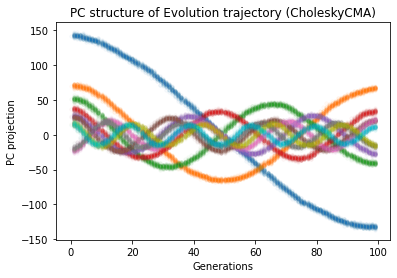

In [ ]:
plt.figure()
for i in range(10):
    plt.scatter(Exp.generations, codes_proj[:, i], s=12,
                label="PC%d"%i, alpha=0.03)
plt.title("PC structure of Evolution trajectory (CholeskyCMA)")
plt.ylabel("PC projection")
plt.xlabel("Generations")
plt.show()

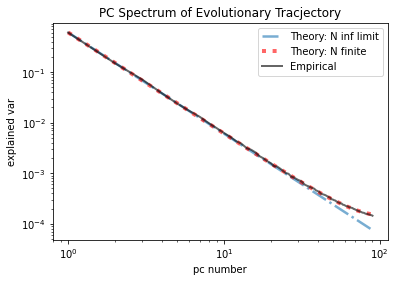

In [ ]:
pca_avg = PCA(n_components=90).fit(avg_codes)
avg_codes_proj = pca_avg.transform(avg_codes)

xticks = np.arange(90)+1
theory_inf = 6/xticks**2/np.pi**2
theory_fin = 1 / (1 - np.cos(np.pi * xticks / 100)) / ((100**2 - 1) / 3)

plt.loglog(xticks, theory_inf,
           lw=2.5, ls="-.", alpha=0.6, label="Theory: N inf limit")
plt.loglog(xticks, theory_fin,
           lw=4, ls=":", color="r", alpha=0.6, label="Theory: N finite")
plt.loglog(xticks, pca_avg.explained_variance_ratio_, 
           label="Empirical", color="k", lw=2, alpha=0.6)
plt.ylabel("explained var")
plt.xlabel("pc number")
plt.title("PC Spectrum of Evolutionary Tracjectory")
plt.legend()
plt.show()

## Our New Spherical Optimizer 

Finally let's try out our newly developed spherical optimizer **SphereCMA**.

*Note, we need to use the init population created by the optimizer, the default starts at original which didn't suits spherical evolution.*

In [ ]:
optim2 = ZOHA_Sphere_lr_euclid(4096, population_size=40, select_size=20, lr=1.5, sphere_norm=300)
optim2.lr_schedule(n_gen=75, mode="exp", lim=(50, 7.33) ,)
explabel, model_unit = "alexnet_fc8_1", ("alexnet", ".classifier.Linear6", 1)
Exp2 = ExperimentEvolution(model_unit, savedir=tmpsavedir, explabel=explabel, optimizer=optim2)
# run evolutions
Exp2.run(init_code=optim2.get_init_pop()) 
# note we need to use the init population created by the optimizer, the default starts at original which didn't suits spherical evolution. 

Gen -1 max score 5.428, mean 0.996, std 1.716
 
First generation
Current Exploration 50.0 deg
synth img scores: mean 0.996 +- std 1.716
step 0  time: total 0.14s | GAN visualize 0.08s   CNN score 0.04s   optimizer step 0.02s
Gen 0 max score 5.747, mean 2.675, std 1.508
 
Step size 0.503, multip learning rate 0.754, 
New basis ang to last samples mean 0.920(0.092), min 0.503
Current Exploration 48.7 deg
synth img scores: mean 2.675 +- std 1.508
step 1  time: total 0.14s | GAN visualize 0.07s   CNN score 0.05s   optimizer step 0.02s
Gen 1 max score 5.922, mean 3.264, std 1.452
 
Step size 0.491, multip learning rate 0.737, 
New basis ang to last samples mean 0.899(0.091), min 0.491
Current Exploration 47.5 deg
synth img scores: mean 3.264 +- std 1.452
step 2  time: total 0.13s | GAN visualize 0.07s   CNN score 0.05s   optimizer step 0.02s
Gen 2 max score 7.484, mean 3.590, std 1.651
 
Step size 0.467, multip learning rate 0.700, 
New basis ang to last samples mean 0.877(0.088), min 0.467

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 720x432 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpp0afire9/temp.m4v


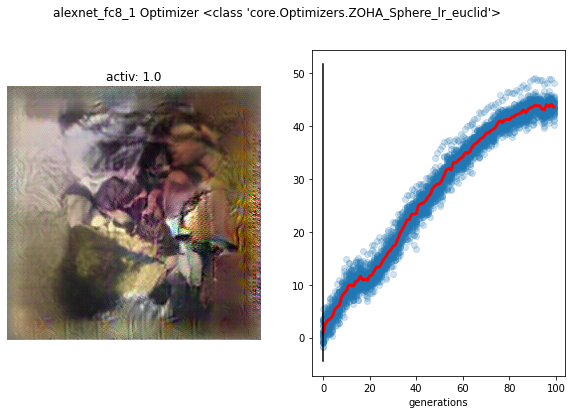

In [ ]:
anim, _ = animate_evol_exp(Exp2)
anim

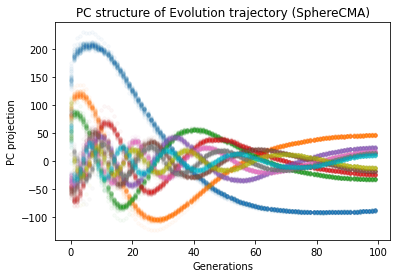

In [ ]:
codes_proj2 = PCA(n_components=50).fit_transform(Exp2.codes_all)
plt.figure()
for i in range(10):
    plt.scatter(Exp2.generations, codes_proj2[:, i], s=12, 
                label="PC%d"%i, alpha=0.03)
plt.title("PC structure of Evolution trajectory (SphereCMA)")
plt.ylabel("PC projection")
plt.xlabel("Generations")
plt.show()